In [41]:
from datascience import *
from datascience.predicates import are
import numpy as np
from scipy import stats
from scipy import misc

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [42]:
united = Table.read_table('united.csv')

In [43]:
pop_mean = np.mean(united.column('Delay'))
pop_mean

15.808622196329742

### Inference about a parameter

The average delay among all the flights is a parameter. We know it: it's roughly 15.81 minutes. But let's suppose we didn't know it, and let's see how to develop an estimate based on a random sample.

In [83]:
# Specify the sample size.

sample_size = 200

In [104]:
# Take a random sample of that size from the population.

sample1 = united.sample(sample_size)

In [105]:
# These are all the data that we have. 
# We can't get any more data directly from the population.

sample1

Date,Flight Number,Destination,Delay
6/5/15,294,STL,3
6/27/15,246,ORD,4
8/25/15,1900,SAN,55
8/7/15,1168,EWR,-1
8/20/15,1683,EWR,95
6/28/15,587,SNA,7
6/12/15,273,SEA,-1
8/18/15,522,PDX,5
7/4/15,1252,MCO,-4
7/4/15,753,DEN,-3


In [106]:
# Get ready to draw a histogram of the sampled delays;
# these are the bins.

every_ten = np.arange(-10, 301, 10)

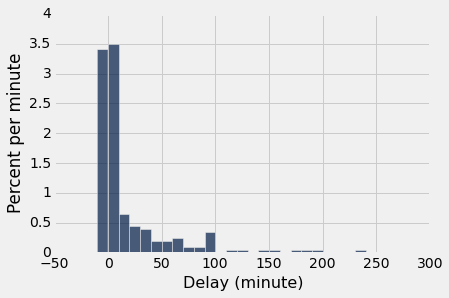

In [107]:
# Histogram of the sampled delays

sample1.select('Delay').hist(bins=every_ten, unit='minute')

In [108]:
# Useful statistic: the mean of the sample
# This is a plausible estimate for the mean of the population,
# because we are betting that the large random sample resembles the population.

np.mean(sample1.column('Delay'))

18.125

### But the sample could have been different ...
So we have to give ourselves some wiggle room in the estimate.

Therefore, **our estimate will be an interval**, not just one number.

To get other plausible estimates, we need other samples. But we don't have other samples; we just have one.

So now what?

### Our sample looks like the population ...
Or at least that's a pretty good bet. Our sample is large and was drawn at random. So it should resemble the population.

### The bootstrap: a brilliant idea

Treat the *sample* as the population, and draw another sample from it!

Careful about sample size. We want another sample of the *same size* as the first one; we're trying to replicate the first sample. 

**The Bootstrap Method**

- We'll use the sample as a proxy for the population, and draw a random sample **from the sample**.
- The amount of sampling variability in an estimate depends on the sample size. So the new sample must have the same size as the original sample. 
- To get a random sample of size 200 from a "population" of size 200, we'll draw at random 200 times **with replacement**.

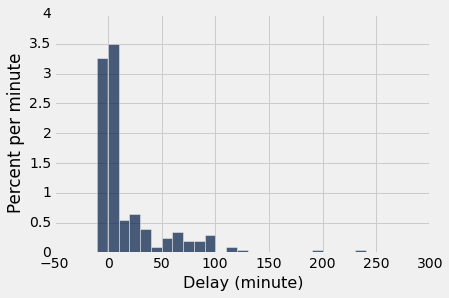

In [110]:
# You don't have to say what the sample size should be.
# The default is to sample as many times as the number of rows of the table.
# Perfect for the bootstrap!

resample = sample1.sample(with_replacement=True)
resample.select('Delay').hist(bins=every_ten, unit='minute')

### A whole lot of plausible estimates
Each of these new samples has a mean. Each of those means is a plausible estimate of the population mean.

In [97]:
# A function that computes the statistic

def sample_mean(table, label):
    return np.mean(table.column(label))

In [98]:
# A function that bootstraps the sample "repetitions" times
# and computes the statistic each time

def bootstrap_repetitions(original_sample, label, statistic, repetitions):
    return np.array([statistic(original_sample.sample(with_replacement=True), label) for i in range(repetitions)])

In [116]:
bootstrap_repetitions(sample1, 'Delay', sample_mean, 10)

array([ 18.455,  17.46 ,  19.485,  14.49 ,  17.73 ,  16.865,  23.835,
        14.9  ,  21.9  ,  20.54 ])

In [117]:
def bootstrap_empirical_distribution(original_sample, label, statistic, repetitions):
    
    # Call bootstrap_repetitions to replicate the statistic
    stats = bootstrap_repetitions(original_sample, label, statistic, repetitions)
    
    # Draw the histogram and label the plot
    Table().with_column('statistic', stats).hist(bins=20)
    plots.xlabel('value of '+ statistic.__name__)
    plots.title('Empirical Distribution ('+str(repetitions)+' samples)')

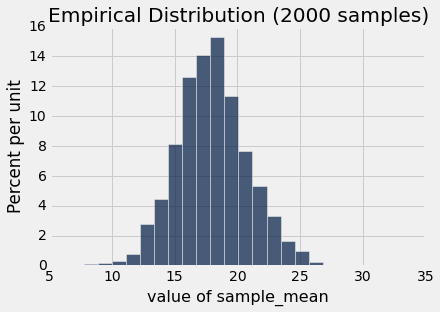

In [119]:
bootstrap_empirical_distribution(sample1, 'Delay', sample_mean, 2000)

### An interval estimate: "confidence interval for the parameter"

Proposed estimate for the parameter: **the middle 95% of this distribution**

In [150]:
def confidence_interval(original_sample, label, parameter, statistic, repetitions):
    # approximate 95% boostrap confidence interval for parameter
    
    # Generate the boostrap replications of the statistic
    # and collect them in a table
    stats = bootstrap_repetitions(original_sample, label, statistic, repetitions)
    bstrap_stats = Table().with_column('statistic', stats)
    
    # Draw the empirical histogram of the replicated statistics
    bstrap_stats.select('statistic').hist(bins=15)
    
    # Get the endpoints of the 95% confidence interval
    left = percentile(2.5, stats)
    right = percentile(97.5, stats)
    
    # Mark the the confidence interval on the horizontal axis
    plots.plot([left, right], [0,0], color='gold', lw=10)
    
    # Print values and labels
    leftend = str(round(left, 2))
    rightend = str(round(right, 2))
    plots.xlabel('value of '+ statistic.__name__)
    plots.title('Empirical Distribution ('+str(repetitions)+' samples)')
    print('Approx 95% bootstrap confidence interval for the ' + parameter +':')
    print(leftend + ' to ' + rightend)
    

Approx 95% bootstrap confidence interval for the population mean:
12.61 to 23.74


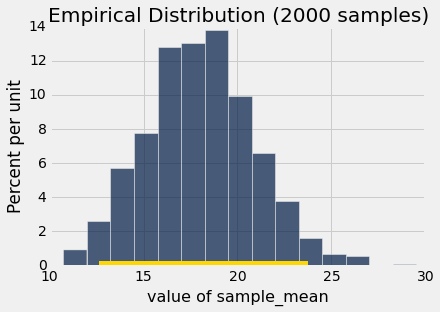

In [151]:
confidence_interval(sample1, 'Delay', 'population mean', sample_mean, 2000)

### The steps of the process

1. Take a random sample from the population.
2. Repeat the following over and over again:
    - Bootstrap the sample
    - Compute the statistic
3. Take the middle 95% of the distribution of the statistics that you calculated.

### Is this process any good?
That is, how likely is it that the interval contains the parameter?

Explore this by repeating the entire process over and over again (from drawing and original sample to coming up with an interval), and see how often the interval contains the parameter (which luckily we happen to know is about 15.81).

In [131]:
# Repeat the entire process, repetitions times

repetitions = 50
intervals = Table(['Left', 'Right'])
for i in range(repetitions):
    first_sample = united.sample(sample_size)
    means = bootstrap_repetitions(first_sample, 'Delay', sample_mean, 2000)
    intervals.append([percentile(2.5, means), percentile(97.5, means)])

In [132]:
intervals

Left,Right
13.715,23.735
12.15,21.955
11.63,22.58
9.325,18.095
11.71,21.58
10.005,17.97
8.315,16.425
11.96,22.325
10.84,18.97
11.385,21.51


In [133]:
# A "good" interval is one that contains the parameter.
# This cell gives the percent of good intervals among all intervals generated.

good = np.logical_and(intervals.column('Left') < pop_mean, intervals.column('Right') > pop_mean)
(np.count_nonzero(good)/repetitions)*100

96.0

About 95% of the intervals contain the parameter. This has been proved in statistical theory, and you can observe it by re-running the code above. 

**Why does the bootstrap method work?**
- The original random sample is large. So with high probability, the original random sample resembles the population.
- With high probability, random samples from the original sample resemble the original sample.
- So with high probability, random samples from the original sample resemble the population too.

**Caution: The bootstrap doesn't always work.** More on that later.

### A random sample; and this time we don't have the population
Here is a typical problem of inference. The data below are from a random sample of mothers who delivered babies in a local hospital system. The goal is to estimate some unknown parameters in the population.

In [61]:
baby = Table.read_table('baby.csv')

In [62]:
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


### Estimating the average maternal age in the population

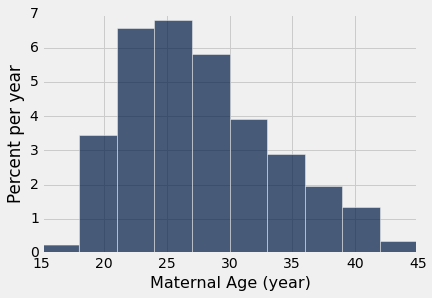

In [63]:
# The distribution of maternal ages in the sample

baby.select('Maternal Age').hist(unit='year')

Approx 95% bootstrap confidence interval for the population mean:
26.91 to 27.57


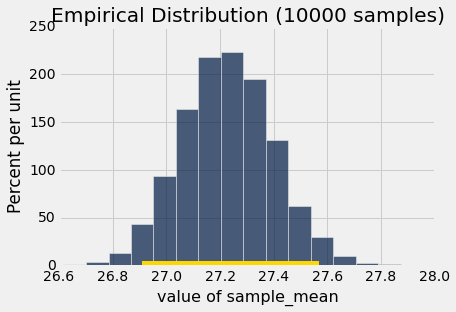

In [152]:
confidence_interval(baby, 'Maternal Age', 'population mean', sample_mean, 10000)

This interval is the result of a process that gives a good answer about 95% of the time. We'll never know whether this interval is good (contains the parameter).Our confidence is in the procedure that generated the interval.

Notice that the empirical distribution of the sample *mean* ages is roughly bell shaped, even though the distribution of the ages in the sample is not.

### The population median
We can use the same bootstrap confidence interval function to estimate the population median.

In [139]:
# A new variable: birth weight relative to gestational days,
# ounces per day

bw_gd = baby.select(['Birth Weight', 'Gestational Days']).with_column(
'BW/GD', baby.column('Birth Weight')/baby.column('Gestational Days'))

In [140]:
bw_gd

Birth Weight,Gestational Days,BW/GD
120,284,0.422535
113,282,0.400709
128,279,0.458781
108,282,0.382979
136,286,0.475524
138,244,0.565574
132,245,0.538776
120,289,0.415225
143,299,0.478261
140,351,0.39886


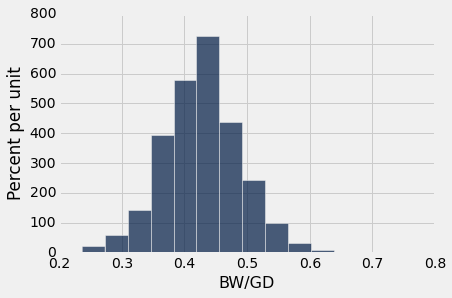

In [153]:
# The distribution of the ratio is almost bell shaped.

bw_gd.select('BW/GD').hist(bins=15)

In [142]:
def sample_median(table, label):
    return np.median(table.column(label))

Approx 95% bootstrap confidence interval for the population median:
0.43 to 0.43


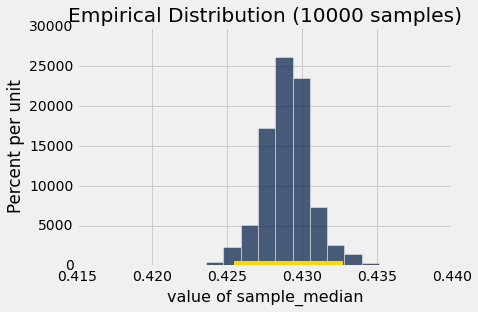

In [154]:
confidence_interval(bw_gd, 'BW/GD', 'population median', sample_median, 10000)